### 1. Evaluation Metrics
We will learn about evaluation metrics for predictive and generative models and how to use them to evaluate our models. It is the post-processing of the model's output to measure its performance in the context of a specific task.

We will use the publicly available IMDB datasets to demonstrate the evaluation metrics on sentiment analysis task.

### 0.1 Preprocessing the data

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords 
import numpy as np

In [2]:
n_samples = 200 # play around with this number to see how it affects the results
imdb_df = pd.read_csv(r"IMDB Dataset.csv")
df_positive = imdb_df[imdb_df['sentiment']=='positive'][:n_samples]
df_negative = imdb_df[imdb_df['sentiment']=='negative'][:n_samples]
imdb = pd.concat([df_positive,df_negative ])
imdb.shape

(400, 2)

In [3]:
# remove "(<.*?>)" markup
imdb['review'] = imdb['review'].apply(lambda x: re.sub('(<.*?>)', ' ', x))
# remove punctuation marks 
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
# remove whitespace
imdb['review'] = imdb['review'].apply(lambda x: x.strip())
# remove all strings that contain a non-letter
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
# convert to lower
imdb['review'] = imdb['review'].apply(lambda x: x.lower())

In [4]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LW\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
print(imdb['review'][3])
words = imdb['review'].apply(lambda x: x.split())
stop_words = set(stopwords.words('english'))
filtered_words = words.apply(lambda x: [w for w in x if not w in stop_words])
imdb['review'] = filtered_words.apply(lambda x: " ".join(x))
imdb['review']=imdb['review'].apply(tagged_lemma)
print(imdb['review'][3])

basically there s a family where a little boy jake thinks there s a zombie in his closet   his parents are fighting all the time  this movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombie  ok first of all when you re going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable parents are divorcing   arguing like in real life and then we have jake with his closet which totally ruins all the film i expected to see a boogeyman similar movie and instead i watched a drama with some meaningless thriller spots    out of    just for the well playing parents   descent dialogs as for the shots with jake just ignore them
basically family little boy jake think zombie closet parent fight time movie slow soap opera suddenly jake decides become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue like real life jake closet totally ruin film expect see boogeyman s

### 0.2 Vectorization and Data Splitting

In [6]:
imdb.sentiment = imdb.sentiment.apply(lambda x: 1 if x=='positive' else 0)

from sklearn.model_selection import train_test_split
train_review, test_review, train_sent, test_sent = train_test_split(imdb['review'], imdb['sentiment'], test_size=0.25, random_state=42)

tv = TfidfVectorizer(stop_words='english')
train_review_tfidf = np.asarray(tv.fit_transform(train_review).todense())
test_review_tfidf = np.asarray(tv.transform(test_review).todense())
print('Tfidf_train:', train_review_tfidf.shape)
print('Tfidf_test:', test_review_tfidf.shape)

Tfidf_train: (300, 7640)
Tfidf_test: (100, 7640)


### 0.3 Sentiment Analysis
Examples shown using SVM Model and Linear Regression Model.

In [7]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')

# Train using the training sets
clf.fit(train_review_tfidf, train_sent)

# Predict the response for test dataset
svm_pred = clf.predict(test_review_tfidf)

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_review_tfidf, train_sent)
lr_pred = lr.predict(test_review_tfidf)

### 1.1 Predictive:
- Confusion Matrix
- F1-score
- Area under ROC curve (AUC-ROC)

SVM:
Accuracy: 0.8
Precision: 0.8
Recall: 0.8


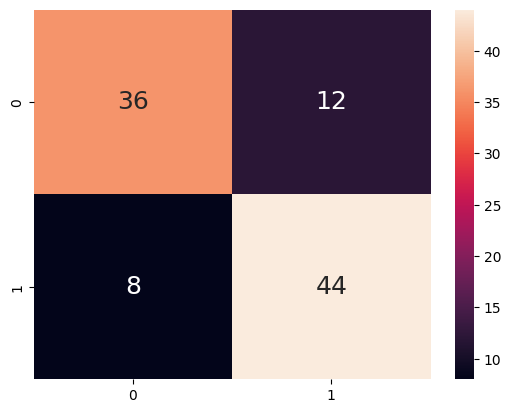

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# generates a confusion matrix between hand labelled data and model predictions
def getConfMatrix(pred_data, actual):
    conf_mat = confusion_matrix(actual, pred_data, labels=[0,1])
    accuracy = accuracy_score(actual, pred_data)
    precision = precision_score(actual, pred_data, average='micro')
    recall = recall_score(actual, pred_data, average='micro')
    sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 18})
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
print("SVM:")
getConfMatrix(svm_pred, test_sent)

Linear Regression:
Accuracy: 0.82
Precision: 0.82
Recall: 0.82


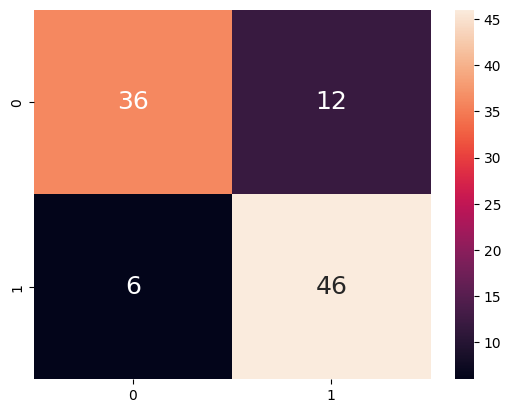

In [10]:
# output of the linear regression model is probabilistic, so we need to convert it to binary using a threshold. Here, we chose 0.5 as the threshold.
print('Linear Regression:')
getConfMatrix((lr_pred > 0.5).astype(int), test_sent)

In [11]:
from sklearn.metrics import f1_score
def get_f1_score(y_true, y_pred):
    micro = f1_score(y_true, y_pred, average='micro') 
    macro = f1_score(y_true,y_pred, average='macro')
    print('F1 Micro: '+ str(micro))
    print('F1 Macro: '+ str(macro))

print("SVM:")
get_f1_score(test_sent, svm_pred)
print("Linear Regression:")
get_f1_score(test_sent, (lr_pred > 0.5).astype(int))

SVM:
F1 Micro: 0.8
F1 Macro: 0.7987117552334944
Linear Regression:
F1 Micro: 0.82
F1 Macro: 0.8181818181818181


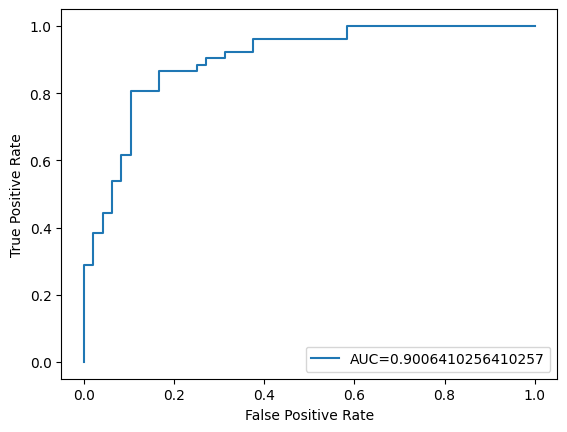

In [12]:
# AUCROC only works on probability predictions, not binary predictions.
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(test_sent,  lr_pred)
auc = metrics.roc_auc_score(test_sent, lr_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### 2. Generative
- BLEU
- ROUGE
- METEOR

In [13]:
import nltk
from nltk import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
ref = 'A fast brown dog jumps over a sleeping fox'
cand = 'A quick brown dog jumps over the fox'
smoothie = SmoothingFunction().method1
reference = word_tokenize(ref)
candidate = word_tokenize(cand)

for i in range(2, 6):
    weights = [1/i for _ in range(i)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], candidate, weights, smoothing_function=smoothie)
    print(f"BLEU score with {i}-grams: {BLEUscore}, input weight: {weights}")

BLEU score with 2-grams: 0.5003287150764929, input weight: [0.5, 0.5]
BLEU score with 3-grams: 0.41914819237589174, input weight: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
BLEU score with 4-grams: 0.3376459109063278, input weight: [0.25, 0.25, 0.25, 0.25]
BLEU score with 5-grams: 0.1956590025947443, input weight: [0.2, 0.2, 0.2, 0.2, 0.2]


In [14]:
# multiple weights can be given, resulting in multiple BLEU scores at once
weights = []
for i in range(2, 6):
    weights.append([1/i for _ in range(i)])
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], candidate, weights, smoothing_function=smoothie)
print(BLEUscore)

[0.5003287150764929, 0.41914819237589174, 0.3376459109063278, 0.1956590025947443]


In [15]:
import evaluate
rouge = evaluate.load('rouge')
references = ['A fast brown dog jumps over a sleeping fox', 
              'A quick brown dog jumps over the fox'], 
predictions = ['The quick brown fox jumps over the lazy dog']
results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': 0.823529411764706, 'rouge2': 0.39999999999999997, 'rougeL': 0.5882352941176471, 'rougeLsum': 0.5882352941176471}


In [16]:
from nltk import skipgrams

def rouge_s(reference, candidate):
    def skip_bigrams(sentence):
        words = sentence.split()
        return set(skipgrams(words, 2, 1))
    
    cand_bigrams = skip_bigrams(candidate)
    print('cand_bigrams:', cand_bigrams)
    max_f1_score = 0
    for ref in reference:
        ref_bigrams = skip_bigrams(ref)
        print('ref_bigrams:', ref_bigrams)
        common_bigrams = ref_bigrams.intersection(cand_bigrams)
        precision = len(common_bigrams) / len(cand_bigrams) if cand_bigrams else 0
        recall = len(common_bigrams) / len(ref_bigrams) if ref_bigrams else 0  
        f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

        max_f1_score = max(max_f1_score, f1_score)  # interested in the best match scenario
    return max_f1_score
print('f1 score: ', rouge_s(reference=['A fast brown dog jumps over a sleeping fox', 
                   'A quick brown dog jumps over the fox'], 
        candidate='The quick brown fox jumps over the lazy dog'))

cand_bigrams: {('over', 'lazy'), ('the', 'lazy'), ('jumps', 'over'), ('over', 'the'), ('quick', 'fox'), ('fox', 'jumps'), ('The', 'brown'), ('jumps', 'the'), ('the', 'dog'), ('brown', 'jumps'), ('brown', 'fox'), ('fox', 'over'), ('quick', 'brown'), ('The', 'quick'), ('lazy', 'dog')}
ref_bigrams: {('dog', 'jumps'), ('A', 'fast'), ('brown', 'dog'), ('jumps', 'over'), ('fast', 'dog'), ('over', 'a'), ('dog', 'over'), ('a', 'sleeping'), ('fast', 'brown'), ('sleeping', 'fox'), ('a', 'fox'), ('jumps', 'a'), ('over', 'sleeping'), ('brown', 'jumps'), ('A', 'brown')}
ref_bigrams: {('dog', 'jumps'), ('jumps', 'over'), ('brown', 'dog'), ('A', 'quick'), ('over', 'the'), ('over', 'fox'), ('the', 'fox'), ('dog', 'over'), ('jumps', 'the'), ('quick', 'dog'), ('brown', 'jumps'), ('quick', 'brown'), ('A', 'brown')}
f1 score:  0.3571428571428571


In [17]:
from nltk.translate import meteor
from nltk import word_tokenize
score=round(meteor([word_tokenize('A fast brown dog jumps over a sleeping fox')],
                   word_tokenize('The quick brown fox jumps over the lazy dog')), 4)
print('The METEOR score is: '+str(score))

The METEOR score is: 0.5679


### 2. Word Embeddings (Word2Vec and GloVe)
Vectorization techniques other than TF-IDF and BOW.

In [18]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Sample sentences for training Word2Vec
sentences = [
    "Word2Vec is a technique for word embedding.",
    "Embedding words in vector space is powerful for NLP.",
    "Gensim provides an easy way to work with Word2Vec.",
]

# Tokenize the sentences into words
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

# Train a Word2Vec model
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, sg=0)  
# Adjust parameters as needed

# Save the trained model for future use
model.save("word2vec.model")

# Load the model (if needed)
# model = Word2Vec.load("word2vec.model")

# Get the word embeddings
word = "word"
if word in model.wv:
    embedding = model.wv[word]
    print(f"Embedding for '{word}': {embedding}")
else:
    print(f"'{word}' is not in the vocabulary.")

# Similarity between words
similarity = model.wv.similarity("word", "embedding")
print(f"Similarity between 'word' and 'embedding': {similarity}")

Embedding for 'word': [-9.5782708e-03  8.9433035e-03  4.1655651e-03  9.2360200e-03
  6.6434164e-03  2.9238823e-03  9.8045552e-03 -4.4228774e-03
 -6.8031684e-03  4.2263791e-03  3.7309569e-03 -5.6647998e-03
  9.7051831e-03 -3.5571249e-03  9.5494138e-03  8.3399686e-04
 -6.3375360e-03 -1.9765303e-03 -7.3783435e-03 -2.9803123e-03
  1.0425968e-03  9.4828764e-03  9.3571255e-03 -6.5945145e-03
  3.4750504e-03  2.2753996e-03 -2.4888995e-03 -9.2287343e-03
  1.0264782e-03 -8.1667695e-03  6.3202251e-03 -5.8006351e-03
  5.5357707e-03  9.8335072e-03 -1.6020649e-04  4.5292759e-03
 -1.8079536e-03  7.3599042e-03  3.9389166e-03 -9.0105701e-03
 -2.3983277e-03  3.6285119e-03 -9.9961828e-05 -1.2015507e-03
 -1.0550468e-03 -1.6715144e-03  6.0320512e-04  4.1645542e-03
 -4.2527826e-03 -3.8329726e-03 -5.2653751e-05  2.6851249e-04
 -1.7041666e-04 -4.7857561e-03  4.3126042e-03 -2.1723476e-03
  2.1040821e-03  6.6577346e-04  5.9687104e-03 -6.8427366e-03
 -6.8160188e-03 -4.4750450e-03  9.4369482e-03 -1.5926627e-03
 -

In [19]:
import gensim.downloader as api

# Load the pre-trained GloVe model (you may need to download it first)
glove_model = api.load("glove-wiki-gigaword-100")

# Find the embedding for a specific word
word = "nero"
try:
    embedding = glove_model[word]
    print(f"Embedding for '{word}':")
    print(embedding)
except KeyError:
    print(f"'{word}' is not in the vocabulary.")

# Find the most similar words to a given word
similar_words = glove_model.most_similar(word)
print(f"\nWords most similar to '{word}':")
for similar_word, score in similar_words:
    print(similar_word, score)

Embedding for 'nero':
[ 0.12703   -1.2517    -0.30333   -0.24548    0.068448   1.1062
  0.30107   -0.33641    0.067003  -0.71713   -0.045462   0.38737
 -0.53082    0.19166   -0.13454   -0.69842    0.43061   -0.1036
  0.33654    0.74012    0.026213  -0.52291   -0.3713     1.0698
  0.61742    0.27974    0.66584   -0.11241    0.0066852  0.1599
  0.16144    0.29823   -0.079172   0.1576     0.20478    1.1741
  0.24823   -0.60665    0.83795    0.44143   -0.31444    0.0040575
  0.19608    0.36953    0.16881   -0.081036  -0.23726   -0.82465
 -0.025315   0.44143   -0.18847    0.2841     0.034934   0.41033
 -0.73196   -0.41349   -0.72422    0.31519   -1.13      -0.2272
  0.080723   0.50456    0.014441   0.14606   -0.15919   -0.54273
 -0.43092   -0.37986   -0.35882   -0.037606   0.51308   -0.2918
  0.46491    0.41077   -0.20835   -1.2477    -0.77411    0.053342
 -0.57954    0.58317    0.56071   -0.16284   -0.3974     0.77043
 -0.58452    0.7157    -0.89662   -0.60718   -0.26547    0.11487
  0.482

### Practice for the Week
Now that you have learned about the evaluation metrics and more of word embeddings and their applications, it's time to encapsulate the provided code into functions/modules so that you don't have to write them again and again. It is especialy important to write modular code when working with large datasets and complex models. 

In [20]:
# This is an example of how to encapsulate the regular expression used to clean the reviews in a function. You may want to save your encapulated function in a separate file for reusability for your project or future use.

def clean_reviews(df, review_column):
    """
    Clean the reviews in the specified column of the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the reviews.
    review_column (str): The name of the column containing the reviews to be cleaned.

    Returns:
    pd.DataFrame: The DataFrame with cleaned reviews.
    """
    # Remove "(<.*?>)" markup
    df[review_column] = df[review_column].apply(lambda x: re.sub(r'(<.*?>)', ' ', x))
    df[review_column] = df[review_column].apply(lambda x: re.sub(r'[,\.\!?:()"]', '', x))
    # Remove whitespace
    df[review_column] = df[review_column].apply(lambda x: x.strip())
    # Remove all strings that contain a non-letter
    df[review_column] = df[review_column].apply(lambda x: re.sub(r'[^a-zA-Z"]', ' ', x))
    # Convert to lower case
    df[review_column] = df[review_column].apply(lambda x: x.lower())
    return df

In [21]:
# suggestions to encaplusate the code into the following parts:
# 1. Dataloader (A dynamic way to load different dataset)
# 2. Raw data preprocessing (cleaning, tokenization, vectorization)
# 3. Model Selection (switch among different model for the task with a change of the input keyword in the function call)
# 4. Metrics (calculate the performance metrics such as accuracy, precision, recall, F1-score, activate the option to plot the result when necessary)